In [1]:
# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd

In [2]:
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）

train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')


In [3]:
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [4]:
# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]


In [5]:
tr_y = tr_y.str[-1:].astype(float)
va_y = va_y.str[-1:].astype(float)
# XGBoostの仕様？　ゼロスタートのため１を引く
tr_y = tr_y - 1
va_y = va_y - 1

#tr_y, va_y

In [6]:
# -----------------------------------
# xgboostの実装
# -----------------------------------
import xgboost as xgb
from sklearn.metrics import log_loss

# 特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)


In [7]:
# ハイパーパラメータの設定
#params = {'objective': 'binary:logistic', 'silent': 1, 'random_state': 71}
params = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 9, 'random_state': 71}
#params = {'objective': 'multi:softmax', 'num_class': 9, 'random_state': 71}
num_round = 50

# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
# watchlistには学習データおよびバリデーションデータをセットする
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist)


[0]	train-merror:0.00575	eval-merror:0.00511
[1]	train-merror:0.00125	eval-merror:0.00129
[2]	train-merror:0.00011	eval-merror:0.00026
[3]	train-merror:0.00000	eval-merror:0.00013
[4]	train-merror:0.00000	eval-merror:0.00013
[5]	train-merror:0.00000	eval-merror:0.00013
[6]	train-merror:0.00000	eval-merror:0.00013
[7]	train-merror:0.00000	eval-merror:0.00013
[8]	train-merror:0.00000	eval-merror:0.00013
[9]	train-merror:0.00000	eval-merror:0.00013
[10]	train-merror:0.00000	eval-merror:0.00013
[11]	train-merror:0.00000	eval-merror:0.00013
[12]	train-merror:0.00000	eval-merror:0.00013
[13]	train-merror:0.00000	eval-merror:0.00013
[14]	train-merror:0.00000	eval-merror:0.00013
[15]	train-merror:0.00000	eval-merror:0.00013
[16]	train-merror:0.00000	eval-merror:0.00013
[17]	train-merror:0.00000	eval-merror:0.00013
[18]	train-merror:0.00000	eval-merror:0.00013
[19]	train-merror:0.00000	eval-merror:0.00013
[20]	train-merror:0.00000	eval-merror:0.00013
[21]	train-merror:0.00000	eval-merror:0.0001

In [162]:
# バリデーションデータでのスコアの確認
va_pred = model.predict(dvalid)

#score = log_loss(va_y.values, va_pred)
#print(f'logloss: {score:.4f}')

# 予測（二値の予測値ではなく、1である確率を出力するようにしている）
pred = model.predict(dtest)

# -----------------------------------
# 学習データとバリデーションデータのスコアのモニタリング
# -----------------------------------
# モニタリングをloglossで行い、アーリーストッピングの観察するroundを20とする
#params = {'objective': 'binary:logistic', 'silent': 1, 'random_state': 71,
#          'eval_metric': 'logloss'}
params = {'objective': 'multi:softmax', 'num_class': 9, 'random_state': 71}
num_round = 500
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20)
#model = xgb.train(params, dtrain, num_round, evals=watchlist)

# 最適な決定木の本数で予測を行う
pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)


[0]	train-merror:0.02083	eval-merror:0.04167
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.01042	eval-merror:0.08333
[2]	train-merror:0.01042	eval-merror:0.08333
[3]	train-merror:0.01042	eval-merror:0.08333
[4]	train-merror:0.01042	eval-merror:0.08333
[5]	train-merror:0.00000	eval-merror:0.08333
[6]	train-merror:0.00000	eval-merror:0.08333
[7]	train-merror:0.00000	eval-merror:0.08333
[8]	train-merror:0.00000	eval-merror:0.08333
[9]	train-merror:0.00000	eval-merror:0.08333
[10]	train-merror:0.00000	eval-merror:0.08333
[11]	train-merror:0.00000	eval-merror:0.08333
[12]	train-merror:0.00000	eval-merror:0.08333
[13]	train-merror:0.00000	eval-merror:0.08333
[14]	train-merror:0.00000	eval-merror:0.08333
[15]	train-merror:0.00000	eval-merror:0.08333
[16]	train-merror:0.00000	eval-merror:0.08333
[17]	train-merror:0.00000	eval-merror:0.08333
[18]	train-merror:0.00000	eval-merr

In [130]:
print(va_y.values)

[0. 0. 0. ... 8. 8. 8.]


## IRIS

In [140]:
import xgboost as xgb

In [163]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_target = pd.Series(iris.target)

In [164]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(iris_data, iris_target, test_size=0.2, shuffle=True)

In [165]:
dtrain = xgb.DMatrix(train_x, label=train_y)

In [166]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 3}

In [167]:
num_round = 10
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
#bst = xgb.train(param, dtrain, num_round, evals=watchlist)
bst = xgb.train(param, dtrain, num_round)

In [168]:
dtest = xgb.DMatrix(test_x)
pred = bst.predict(dtest)

In [169]:
from sklearn.metrics import accuracy_score

score = accuracy_score(test_y, pred)
print('score:{0:.4f}'.format(score))
# 0.9667

score:0.9667


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

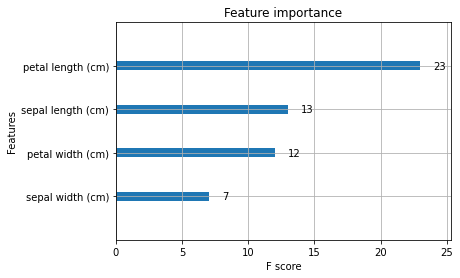

In [170]:
xgb.plot_importance(bst)

In [171]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True)

In [172]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


In [174]:
#param = {'max_depth': 2, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'mlogloss'}
param = {'max_depth': 2, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 3}


In [175]:
evallist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5)
# [0]   eval-mlogloss:0.61103   train-mlogloss:0.60698
# Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.
# 
# Will train until train-mlogloss hasn't improved in 5 rounds.
# [1]   eval-mlogloss:0.36291   train-mlogloss:0.35779
# [2]   eval-mlogloss:0.22432   train-mlogloss:0.23488
# 
# 〜〜〜 途中省略 〜〜〜
# 
# Stopping. Best iteration:
# [1153]    eval-mlogloss:0.00827   train-mlogloss:0.01863


[0]	eval-merror:0.00000	train-merror:0.05208
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 5 rounds.
[1]	eval-merror:0.00000	train-merror:0.03125
[2]	eval-merror:0.00000	train-merror:0.03125
[3]	eval-merror:0.00000	train-merror:0.04167
[4]	eval-merror:0.00000	train-merror:0.03125
[5]	eval-merror:0.00000	train-merror:0.03125
[6]	eval-merror:0.00000	train-merror:0.01042
[7]	eval-merror:0.00000	train-merror:0.01042
[8]	eval-merror:0.00000	train-merror:0.01042
[9]	eval-merror:0.00000	train-merror:0.00000
[10]	eval-merror:0.00000	train-merror:0.00000
[11]	eval-merror:0.00000	train-merror:0.00000
[12]	eval-merror:0.00000	train-merror:0.00000
[13]	eval-merror:0.04167	train-merror:0.00000
[14]	eval-merror:0.04167	train-merror:0.00000
Stopping. Best iteration:
[9]	eval-merror:0.00000	train-merror:0.00000



In [155]:
print('Best Score:{0:.4f}, Iteratin:{1:d}, Ntree_Limit:{2:d}'.format(
     bst.best_score, bst.best_iteration, bst.best_ntree_limit))
# Best Score:0.0186, Iteratin:1153, Ntree_Limit:1154

Best Score:0.0150, Iteratin:819, Ntree_Limit:820


In [156]:
dtest = xgb.DMatrix(test_x)
pred = ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [157]:
pred

array([0., 0., 2., 2., 2., 1., 0., 2., 0., 0., 1., 0., 1., 0., 1., 2., 2.,
       2., 1., 0., 1., 2., 1., 1., 0., 2., 1., 1., 1., 2.], dtype=float32)

## load_boston
回帰モデル（連続性）

In [176]:
import pandas as pd
from sklearn.datasets import load_boston
data = load_boston()
df = pd.DataFrame(data["data"], columns = data["feature_names"])
df["target"] = data["target"]
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [177]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True) # データを分割してくれる関数
df["fold"] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
    df.loc[valid_idx, "fold"] = fold
print(df["fold"].value_counts())

0    102
4    101
1    101
2    101
3    101
Name: fold, dtype: int64


In [179]:
fold = 0
train = df.loc[df["fold"] != fold].copy()
valid = df.loc[df["fold"] == fold].copy()
print(train.shape, valid.shape)

(404, 15) (102, 15)


In [180]:
feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

X_train = train[feat_cols]
X_valid = valid[feat_cols]
y_train = train["target"]
y_valid = valid["target"]

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [181]:
import xgboost as xgb

In [182]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

In [183]:
params = {
    "objective" : "reg:squarederror", # モデルの種類(回帰や分類など) reg:squarederror >> 回帰モデル “reg”は回帰の”regression”で”squarederror”は二乗誤差
    "eval_metric" : "rmse"            # 評価指標(rmseやaucなど) “rmse”は平均二乗誤差の平方根
}

In [184]:
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")], # ”eval_metric”で評価するデータ
    num_boost_round = 100 # モデルを作り直す回数
)

[0]	train-rmse:16.92838	valid-rmse:17.76331
[1]	train-rmse:12.24897	valid-rmse:13.00863
[2]	train-rmse:8.90675	valid-rmse:9.60274
[3]	train-rmse:6.58346	valid-rmse:7.17495
[4]	train-rmse:4.92304	valid-rmse:5.59126
[5]	train-rmse:3.74327	valid-rmse:4.66431
[6]	train-rmse:2.91932	valid-rmse:4.05327
[7]	train-rmse:2.36707	valid-rmse:3.68168
[8]	train-rmse:1.94761	valid-rmse:3.48065
[9]	train-rmse:1.66779	valid-rmse:3.37206
[10]	train-rmse:1.47670	valid-rmse:3.36365
[11]	train-rmse:1.33915	valid-rmse:3.31279
[12]	train-rmse:1.23641	valid-rmse:3.26601
[13]	train-rmse:1.14093	valid-rmse:3.25281
[14]	train-rmse:1.00827	valid-rmse:3.23062
[15]	train-rmse:0.95879	valid-rmse:3.21524
[16]	train-rmse:0.92139	valid-rmse:3.22536
[17]	train-rmse:0.88723	valid-rmse:3.22268
[18]	train-rmse:0.83481	valid-rmse:3.21473
[19]	train-rmse:0.79302	valid-rmse:3.19422
[20]	train-rmse:0.73273	valid-rmse:3.18955
[21]	train-rmse:0.69720	valid-rmse:3.17054
[22]	train-rmse:0.65276	valid-rmse:3.17347
[23]	train-rmse:0

In [185]:
# predictで予測結果を出力
pred = model.predict(xgb.DMatrix(X_valid))
print(pred)

[34.602875  21.462439  18.72736   21.220026  19.141644  16.206978
 16.613173  13.357844  13.716306  23.852552  17.234896  35.068787
 30.229706  22.441782  24.08176   24.770409  22.139935  22.783014
 20.910812  25.399553  25.399197  39.544056  32.470833  24.355314
 20.527443  20.87544   18.42293   21.403395  19.114504  23.833168
 23.590574  20.698988  19.816132  16.19684   17.369795  15.556119
 13.136945  13.68541   41.451305  24.004566  41.998074  33.570583
 46.451927  36.424664  23.103352  19.977278  22.784954  24.085375
 18.597336  49.176884  47.32761   33.78188   33.404446  26.84733
 23.048439  35.129192  40.98539   39.50284   21.397228  35.109264
 31.629221  44.27803   32.656635  27.737375  32.5818    22.084818
 19.82467   19.407963  22.293482  23.70385   19.726803  19.93676
 20.201893  19.922138  27.787174  22.428144  18.542398  21.763653
 20.16682   39.90108   14.998258  11.805703  12.407137  14.254348
 17.05245   15.2328825 16.37517    7.836231  11.182522  15.642363
 17.171896  

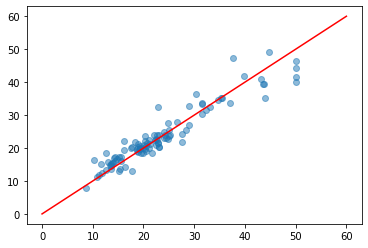

In [187]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(y_valid, pred, alpha = 0.5)
plt.plot(np.linspace(0, 60, 100), np.linspace(0, 60, 100), "red")
plt.show()

# 横軸を正解データ、縦軸を予測値

In [188]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, pred)
rmse = np.sqrt(mse)
print(rmse)

3.152503767889867


In [191]:
# 学習状況可視化
results_dict = {} # ここに学習状況が記録される
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")],
    num_boost_round = 100,
    early_stopping_rounds = 10,
    evals_result = results_dict
)

[0]	train-rmse:16.92838	valid-rmse:17.76331
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:12.24897	valid-rmse:13.00863
[2]	train-rmse:8.90675	valid-rmse:9.60274
[3]	train-rmse:6.58346	valid-rmse:7.17495
[4]	train-rmse:4.92304	valid-rmse:5.59126
[5]	train-rmse:3.74327	valid-rmse:4.66431
[6]	train-rmse:2.91932	valid-rmse:4.05327
[7]	train-rmse:2.36707	valid-rmse:3.68168
[8]	train-rmse:1.94761	valid-rmse:3.48065
[9]	train-rmse:1.66779	valid-rmse:3.37206
[10]	train-rmse:1.47670	valid-rmse:3.36365
[11]	train-rmse:1.33915	valid-rmse:3.31279
[12]	train-rmse:1.23641	valid-rmse:3.26601
[13]	train-rmse:1.14093	valid-rmse:3.25281
[14]	train-rmse:1.00827	valid-rmse:3.23062
[15]	train-rmse:0.95879	valid-rmse:3.21524
[16]	train-rmse:0.92139	valid-rmse:3.22536
[17]	train-rmse:0.88723	valid-rmse:3.22268
[18]	train-rmse:0.83481	valid-rmse:3.21473
[19]	train-rmse:0.79302	valid-rmse:3.19422
[

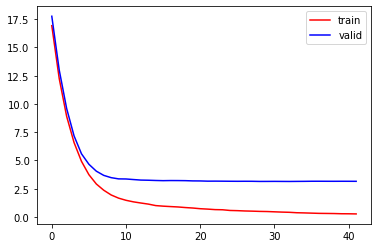

In [192]:
plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
plt.plot(results_dict["valid"]["rmse"], color = "blue", label = "valid")
plt.legend()
plt.show()

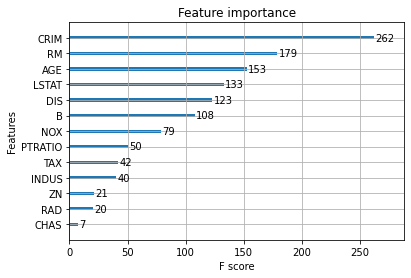

In [196]:
# 特徴量重要度
xgb.plot_importance(model)
plt.show()

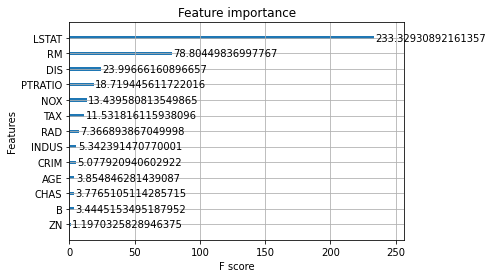

In [197]:
xgb.plot_importance(model, importance_type = "gain")
plt.show()

## load_breast_cancer
二値分類モデル（1　か　0）

In [198]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data["data"], columns = data["feature_names"])
df["target"] = data["target"]
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [201]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True) # 予測したいラベルの割合を保ちながら分割して
df["fold"] = -1
for fold, (train_idx, valid_idx) in enumerate(skf.split(X = df, y = df["target"])):
    df.loc[valid_idx, "fold"] = fold
print(df["fold"].value_counts())

2    114
3    114
1    114
0    114
4    113
Name: fold, dtype: int64


In [200]:
fold = 0
train = df.loc[df["fold"] != fold].copy()
valid = df.loc[df["fold"] == fold].copy()
print(train.shape, valid.shape)

feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

X_train = train[feat_cols]
X_valid = valid[feat_cols]
y_train = train["target"]
y_valid = valid["target"]

(455, 32) (114, 32)
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [203]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

params = {
    "objective" : "binary:logistic", # “binary:logistic” 二値分類の場合
    "eval_metric" : "logloss" # logloss 予測結果が外れたとき、その予測確立が大きいほどペナルティを与えます。
}

results_dict = {}
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")],
    num_boost_round = 100,
    early_stopping_rounds = 10,
    evals_result = results_dict
)

[0]	train-logloss:0.46579	valid-logloss:0.47726
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.33483	valid-logloss:0.34509
[2]	train-logloss:0.24781	valid-logloss:0.26144
[3]	train-logloss:0.18933	valid-logloss:0.20467
[4]	train-logloss:0.14738	valid-logloss:0.16706
[5]	train-logloss:0.11709	valid-logloss:0.14136
[6]	train-logloss:0.09477	valid-logloss:0.12139
[7]	train-logloss:0.07865	valid-logloss:0.10253
[8]	train-logloss:0.06649	valid-logloss:0.09008
[9]	train-logloss:0.05586	valid-logloss:0.08117
[10]	train-logloss:0.04761	valid-logloss:0.07527
[11]	train-logloss:0.04103	valid-logloss:0.07134
[12]	train-logloss:0.03584	valid-logloss:0.06342
[13]	train-logloss:0.03236	valid-logloss:0.06073
[14]	train-logloss:0.02852	valid-logloss:0.05514
[15]	train-logloss:0.02543	valid-logloss:0.05384
[16]	train-logloss:0.02321	valid-logloss:0.05001
[17]	train-logloss:0.02136

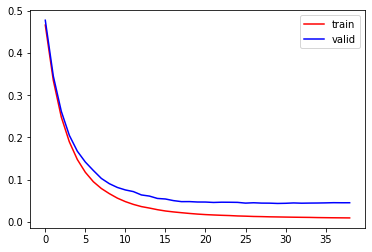

In [204]:
import matplotlib.pyplot as plt
plt.plot(results_dict["train"]["logloss"], color = "red", label = "train")
plt.plot(results_dict["valid"]["logloss"], color = "blue", label = "valid")
plt.legend()
plt.show()

In [205]:
# 予測結果
pred = model.predict(xgb.DMatrix(X_valid))
print(pred) # ”ラベル１である確率”

[3.6165959e-03 8.8438299e-04 1.2680969e-03 6.4587735e-02 5.2499510e-03
 9.9852139e-01 7.7069034e-03 2.2920740e-03 3.6545503e-03 1.2966181e-02
 9.9730128e-01 1.1560434e-03 1.1275444e-03 1.8593248e-03 1.9822498e-03
 9.9925500e-01 9.9902368e-01 9.9077320e-01 9.6547045e-02 9.9903357e-01
 9.9871266e-01 6.3627118e-01 9.7582561e-01 8.5153419e-01 9.9746561e-01
 9.9053627e-01 9.9909031e-01 9.9112320e-01 9.9851865e-01 8.7224379e-02
 9.9875426e-01 9.9904114e-01 9.9490190e-01 9.9918967e-01 9.7175911e-02
 9.9833018e-01 8.4850544e-01 2.4550685e-01 9.9500066e-01 1.1275444e-03
 3.2554406e-03 9.9764818e-01 1.3338348e-03 9.8366815e-01 1.3664106e-03
 9.9811578e-01 9.7224528e-01 1.2127600e-03 1.0720406e-03 7.9777390e-03
 9.9949551e-01 1.1592386e-03 7.2120328e-04 9.9795485e-01 9.9721718e-01
 9.9954575e-01 9.8049200e-01 9.9622041e-01 9.9963689e-01 9.9841595e-01
 9.9887937e-01 9.9809366e-01 6.5982743e-04 9.9692613e-01 9.9883181e-01
 8.4628345e-04 8.0907944e-04 6.4668816e-04 9.9861813e-01 9.9939239e-01
 1.882

In [209]:
import numpy as np
label = np.where(pred > 0.5, 1, 0)
print(label)

[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 1]


In [210]:
print(label)
print("=" * 100)
print(y_valid.values)

[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 1]
[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 0 1]


In [211]:
label == y_valid.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [214]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, label)
print('正解率: ', acc)

正解率:  0.9824561403508771


In [215]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_valid, pred)
print('AUC: ', auc)

AUC:  0.9990173599737963


## 多クラス分類モデル

In [216]:
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data["data"], columns = data["feature_names"])
df["target"] = data["target"]
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [218]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 3, shuffle = True)
df["fold"] = -1
for fold, (train_idx, valid_idx) in enumerate(skf.split(X = df, y = df["target"])):
    df.loc[valid_idx, "fold"] = fold
print(df["fold"].value_counts())

1    50
2    50
0    50
Name: fold, dtype: int64


In [219]:
fold = 0
train = df.loc[df["fold"] != fold].copy()
valid = df.loc[df["fold"] == fold].copy()
print(train.shape, valid.shape)

feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

X_train = train[feat_cols]
X_valid = valid[feat_cols]
y_train = train["target"]
y_valid = valid["target"]

(100, 6) (50, 6)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [229]:
type(y_train)

pandas.core.series.Series

In [226]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

params = {
    #"objective" : "multi:softprob",
    "objective" : "multi:softmax",
    "eval_metric" : "mlogloss", # mは複数を意味
    "num_class" : 3 # （ラベルの種類数）
}

results_dict = {}
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dvalid, "valid")],
    num_boost_round = 100,
    early_stopping_rounds = 10,
    evals_result = results_dict
)

[0]	train-mlogloss:0.76020	valid-mlogloss:0.74778
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:0.55107	valid-mlogloss:0.52798
[2]	train-mlogloss:0.41421	valid-mlogloss:0.38781
[3]	train-mlogloss:0.32053	valid-mlogloss:0.28938
[4]	train-mlogloss:0.25336	valid-mlogloss:0.22043
[5]	train-mlogloss:0.20467	valid-mlogloss:0.17075
[6]	train-mlogloss:0.16754	valid-mlogloss:0.13347
[7]	train-mlogloss:0.13935	valid-mlogloss:0.10462
[8]	train-mlogloss:0.11911	valid-mlogloss:0.08522
[9]	train-mlogloss:0.10330	valid-mlogloss:0.07114
[10]	train-mlogloss:0.08943	valid-mlogloss:0.06245
[11]	train-mlogloss:0.07820	valid-mlogloss:0.05527
[12]	train-mlogloss:0.06878	valid-mlogloss:0.04819
[13]	train-mlogloss:0.06127	valid-mlogloss:0.04263
[14]	train-mlogloss:0.05651	valid-mlogloss:0.03943
[15]	train-mlogloss:0.05122	valid-mlogloss:0.03694
[16]	train-mlogloss:0.04782	valid-mloglos

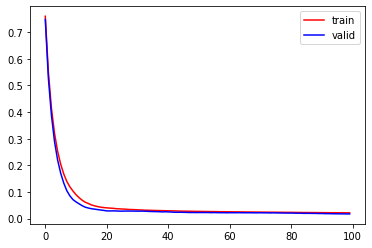

In [227]:
import matplotlib.pyplot as plt
plt.plot(results_dict["train"]["mlogloss"], color = "red", label = "train")
plt.plot(results_dict["valid"]["mlogloss"], color = "blue", label = "valid")
plt.legend()
plt.show()

In [228]:
pred = model.predict(xgb.DMatrix(X_valid))
print(pred.shape)
print(pred)

(50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2.]


In [223]:
label = pred.argmax(axis = 1)
print(label)
print("=" * 100)
print(y_valid.values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [224]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, label)
print(acc)

1.0


In [225]:
# 多クラス分類ではAUCを計算できない
# 適合率(Precision)と再現率(Recall)を計算し、
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_valid.values, label, average = "micro")
recall = recall_score(y_valid.values, label, average = "micro")
print(precision, recall)

1.0 1.0
